#### **1. Importando Pacote e módulos necessários**

Instalação dos pacotes necessários.

In [ ]:
%pip install seaborn
%pip install scikit-learn
%pip install matplotlib
%pip install aisp

Importação dos pacotes

In [2]:
# Importando a seleção negativa.
from aisp.nsa import BNSA

# Importando os demais pacotes. 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Função para gerar amostras binárias
Nesta função, são geradas amostras de dados binários com um grau de similaridade abaixo de um limiar definido s. No entanto, 10% dos primeiros dados são gerados aleatoriamente, sem levar em consideração o valor de s. Além disso, quando já existem amostras, são geradas amostras únicas para a nova classe, garantindo que as amostras aleatórias geradas não estejam duplicadas em classes diferentes.

In [3]:
def generate_samples(n_samples: int, n_features: int, s: float, x: None):
  classe_samples = []
  while len(classe_samples) < n_samples:
    similarity = 0
    sample_rand = np.random.randint(0, 2, size=(n_features))
    if(len(classe_samples) > max(int(n_samples * 0.1), 1)):
      similarity = cdist(classe_samples, np.expand_dims(sample_rand, axis=0), metric='hamming')[0, :]
      if x is not None:
        if similarity[0] <= s and not np.any(np.all(sample_rand == x, axis=1)):
          classe_samples.append(sample_rand)
      elif similarity[0] <= s:
        classe_samples.append(sample_rand)
    else:
      classe_samples.append(sample_rand)
  return np.array(classe_samples)

# Geração e separação de dados
Nessa etapa, são gerados 1000 dados, sendo 500 para representar a classe 'x' e 500 para representar a classe 'y'. Cada dado é formado por 20 dimensões. É importante destacar que esses dados são criados de forma que apresentem um grau de similaridade de 80%, ou seja, compartilham características comuns. Após a geração, os dados são separados em conjuntos de treinamento e teste.

In [4]:
# Configurando a seed para 121 para garantir a reprodutibilidade dos dados gerados.
np.random.seed(121)
# Gerando amostras para a classe "A".
x = generate_samples(500, 20, 0.2, None)
# Gerando amostras exclusivas para a classe "B", diferentes das amostras presentes na classe "A".
y = generate_samples(500, 20, 0.2, x)
# Adicionando colunas contendo as saídas (rótulos) das classes "A" e "B".
x = np.hstack((x, np.full((x.shape[0], 1), 'A')))
y = np.hstack((y, np.full((y.shape[0], 1), 'B')))
# Juntando os dois vetores (classes "A" e "B") e randomizando a ordem das amostras.
index = np.random.permutation(x.shape[0]*2)
dataset = np.vstack((x, y))[index]

# Separando as características (inputs) e as classes de saída (rótulos).
samples = dataset[:, :-1].astype(int)
output = dataset[:, -1]
# Separating data for training and testing.
train_x, test_x, train_y, test_y = train_test_split(samples, output, test_size=0.2, random_state=1234321)

# Testando o modelo

### Método da Distância Máxima Média para Rotular Amostras Não-próprias

Iniciando o modelo e aplicando-o às amostras geradas aleatoriamente, a configuração atual possui 250 detectores com uma taxa de diferenciação de 30%.

In [6]:
# Iniciando a classe.
nsa = BNSA(N=250, aff_thresh=0.3, seed=1234321, max_discards=100000)
# Efetuando o treinamento: 
nsa.fit(X=train_x, y=train_y)
# Efetuando a previsão:: 
prev = nsa.predict(X=test_x)
# Mostrando a acurácia das previsões para os dados reais.
print(f"A acurácia é {accuracy_score(prev, test_y)}")
print(classification_report(test_y, prev))

✔ Non-self detectors for classes (A, B) successfully generated:  ┇██████████┇ 500/500 detectors


A acurácia é 0.93
              precision    recall  f1-score   support

           A       0.93      0.91      0.92        90
           B       0.93      0.95      0.94       110

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



# Matriz de confusão
Aqui está a matriz de confusão, onde a diagonal principal representa as amostras previstas corretamente e a diagonal secundária mostra os falsos positivos. Dos 200 dados de teste, houve 6 falsos positivos para a classe A e 8 falsos positivos para a classe B.

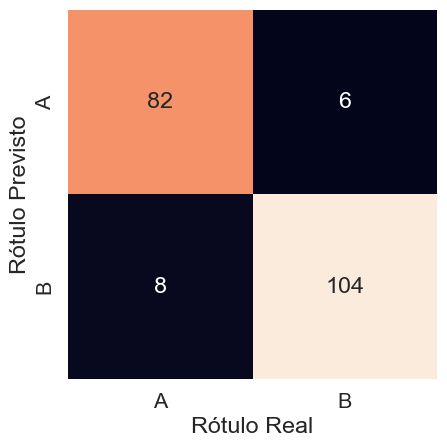

In [7]:
# Gerando a matriz de confusão e plotando de forma gráfica.
mat = confusion_matrix(y_true=test_y, y_pred=prev)
sns.set(font_scale=1.4) 
sns.heatmap(
    mat.T, 
    square=True, 
    annot=True, 
    fmt='d', 
    cbar=False, 
    xticklabels=nsa.classes,
    yticklabels=nsa.classes
)
plt.xlabel('Rótulo Real')
plt.ylabel('Rótulo Previsto')
plt.show()

# Testando o modelo

### Método da Distância Máxima Média para Rotular Amostras Não-próprias

Iniciando o modelo e aplicando-o às amostras geradas aleatoriamente, a configuração atual possui 250 detectores com uma taxa de diferenciação de 30%.

In [9]:
# Iniciando a classe.
nsa = BNSA(N=250, aff_thresh=0.3, seed=1234321, max_discards=100000, no_label_sample_selection="max_nearest_difference")
# Efetuando o treinamento: 
nsa.fit(X=train_x, y=train_y)
# Efetuando a previsão:: 
prev = nsa.predict(X=test_x)
# Mostrando a acurácia das previsões para os dados reais.
print(f"A acurácia é {accuracy_score(prev, test_y)}")
print(classification_report(test_y, prev))

✔ Non-self detectors for classes (A, B) successfully generated:  ┇██████████┇ 500/500 detectors


A acurácia é 0.93
              precision    recall  f1-score   support

           A       0.93      0.91      0.92        90
           B       0.93      0.95      0.94       110

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



# Matriz de confusão
Aqui está a matriz de confusão, onde a diagonal principal representa as amostras previstas corretamente e a diagonal secundária mostra os falsos positivos. Dos 200 dados de teste, houve 6 falsos positivos para a classe A e 8 falsos positivos para a classe B.

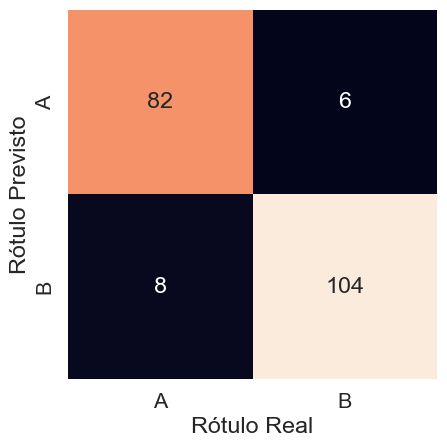

In [10]:
# Gerando a matriz de confusão e plotando de forma gráfica.
mat = confusion_matrix(y_true=test_y, y_pred=prev)
sns.set(font_scale=1.4) 
sns.heatmap(
    mat.T, 
    square=True, 
    annot=True, 
    fmt='d', 
    cbar=False, 
    xticklabels=nsa.classes,
    yticklabels=nsa.classes
)
plt.xlabel('Rótulo Real')
plt.ylabel('Rótulo Previsto')
plt.show()